In [1]:
import pyopenms as oms
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy as np
import sys
sys.path.append(r"..")
import microspot_util as msu
import microspot_util.plots as plots

2023-11-28 14:17:56.204 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-28 14:17:56.221 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-28 14:17:56.235 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-28 14:17:56.240 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-28 14:17:56.243 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-11-28 14:17:56.247 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


In [2]:
exp = oms.MSExperiment()
oms.MzMLFile().load("../test_mzml/231004_TestAB_1.mzML", exp)

exp.sortSpectra(True)

mass_traces = []
mtd = oms.MassTraceDetection()
mtd_params = mtd.getDefaults()
mtd_params.setValue(
    "mass_error_ppm", 10.0
)  # set according to your instrument mass error
mtd_params.setValue(
    "noise_threshold_int", 10000.0
)  # adjust to noise level in your data
mtd.setParameters(mtd_params)
mtd.run(exp, mass_traces, 0)

mass_traces_split = []
mass_traces_final = []
epd = oms.ElutionPeakDetection()
epd_params = epd.getDefaults()
epd_params.setValue("width_filtering", "fixed")
epd.setParameters(epd_params)
epd.detectPeaks(mass_traces, mass_traces_split)

if epd.getParameters().getValue("width_filtering") == "auto":
    epd.filterByPeakWidth(mass_traces_split, mass_traces_final)
else:
    mass_traces_final = mass_traces_split

fm = oms.FeatureMap()
feat_chrom = []
ffm = oms.FeatureFindingMetabo()
ffm_params = ffm.getDefaults()
ffm_params.setValue("isotope_filtering_model", "none")
ffm_params.setValue(
    "remove_single_traces", "true"
)  # set false to keep features with only one mass trace
ffm_params.setValue("mz_scoring_by_elements", "false")
ffm_params.setValue("report_convex_hulls", "true")
ffm.setParameters(ffm_params)
ffm.run(mass_traces_final, fm, feat_chrom)

fm.setUniqueIds()
ft=fm.get_df()
ft

Progress of 'mass trace detection':
-- done [took 1.24 s (CPU), 1.33 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 0.04 s (CPU), 0.01 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 0.08 s (CPU), 0.01 s (Wall)] -- 


,peptide_sequence,peptide_score,ID_filename,ID_native_id,charge,RT,mz,RTstart,RTend,MZstart,MZend,quality,intensity
feature_id,,,,,,,,,,,,,
6767063646194852008,None,NaN,None,None,3,68.554974,155.440068,64.942854,78.451854,155.440002,155.774719,0.001733,1.425945e+08
16735694610431983132,None,NaN,None,None,3,68.554974,160.112041,65.570604,79.924986,160.112000,160.446777,0.001793,1.450977e+08
1320350986817941854,None,NaN,None,None,1,70.840860,176.091182,63.663474,88.217862,176.091110,177.094849,0.012198,1.055077e+09
9102682054356520537,None,NaN,None,None,3,70.840860,194.761979,66.282102,82.290612,194.761856,195.096848,0.002708,2.159362e+08
13572990682444949415,None,NaN,None,None,3,71.461980,200.765506,63.663474,88.217862,200.765442,201.768204,0.091353,6.203111e+09
6697970246549499264,None,NaN,None,None,2,223.760178,204.618468,220.997550,230.708178,204.618393,205.120193,0.000900,7.186865e+07
12835397774742934044,None,NaN,None,None,3,71.461980,205.434618,66.709224,79.924986,205.434494,205.769669,0.001192,9.528151e+07
2768313633709075955,None,NaN,None,None,3,74.056608,214.438169,66.282102,84.818988,214.438019,214.773453,0.001596,1.281631e+08
11412202332391844271,None,NaN,None,None,2,68.554974,225.643409,64.942854,87.363738,225.643250,226.145432,0.002629,2.083203e+08


,peak_idx,RT,width,left_ips,right_ips,norm_intensity,AUC
7,7,67.0,10.262323,2,12,1.018611,5.454886
178,178,238.0,4.196609,175,179,0.042582,0.087220


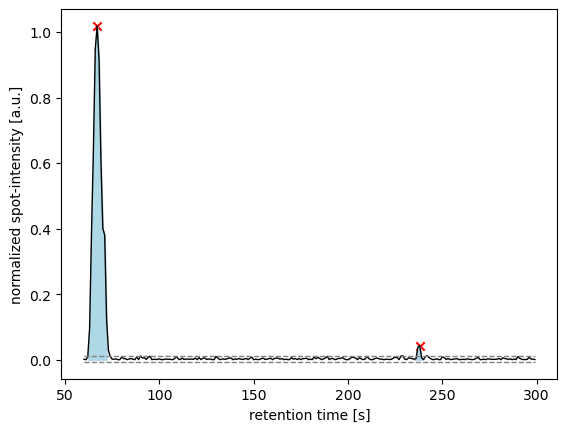

In [3]:
at=pd.read_csv("../output/merged_data_baselinecorr.csv",index_col=0)
at.sort_values("RT",inplace=True)

mn_old=at.norm_intensity.mean()
std_old=at.norm_intensity.std()

rmsd=10
while rmsd>0.02:
    test=at.loc[at.norm_intensity<mn_old+3*std_old,"norm_intensity"]
    mn_new=test.mean()
    std_new=test.std()
    
    rmsd=np.sqrt(np.mean((std_new-std_old)**2))
    
    mn_old=mn_new
    std_old=std_new

peaks,_=signal.find_peaks(at.norm_intensity,height=mn_old+3*std_old,distance=10)

width,width_heigths,left_ips,right_ips=signal.peak_widths(at.norm_intensity,peaks,0.95)

aft=pd.DataFrame({"peak_idx":peaks,"RT":at.loc[peaks,"RT"],"width":width,"left_ips":left_ips.astype("int32"),"right_ips":right_ips.astype("int32"),"norm_intensity":at.loc[peaks,"norm_intensity"],"AUC":np.nan})

for idx in aft.index:
    aft.loc[idx,"AUC"]=np.trapz(at.loc[aft.loc[idx,"left_ips"]:aft.loc[idx,"right_ips"],"norm_intensity"])

fig,ax=plt.subplots()
ax.plot(at.RT,at.norm_intensity,c="k",linewidth=1)
ax.set(ylabel="normalized spot-intensity [a.u.]",xlabel="retention time [s]")
ax.scatter(aft.RT,aft.norm_intensity,marker="x",c="red")
ax.hlines([mn_old+3*std_old,mn_old-3*std_old],xmin=at.RT.min(),xmax=at.RT.max(),linewidth=1,colors="gray",ls="--")
for idx in aft.index:
    ax.fill_between(at.RT.loc[aft.loc[idx,"left_ips"]:aft.loc[idx,"right_ips"]],at.norm_intensity.loc[aft.loc[idx,"left_ips"]:aft.loc[idx,"right_ips"]],color="lightblue")

aft

In [4]:
msu.activity_annotation_features(ft,aft)

ft

,peptide_sequence,peptide_score,ID_filename,ID_native_id,charge,RT,mz,RTstart,RTend,MZstart,MZend,quality,intensity,activity@67.0s,activity@238.0s
feature_id,,,,,,,,,,,,,,,
6767063646194852008,None,NaN,None,None,3,68.554974,155.440068,64.942854,78.451854,155.440002,155.774719,0.001733,1.425945e+08,5.454886,NaN
16735694610431983132,None,NaN,None,None,3,68.554974,160.112041,65.570604,79.924986,160.112000,160.446777,0.001793,1.450977e+08,5.454886,NaN
1320350986817941854,None,NaN,None,None,1,70.840860,176.091182,63.663474,88.217862,176.091110,177.094849,0.012198,1.055077e+09,5.454886,NaN
9102682054356520537,None,NaN,None,None,3,70.840860,194.761979,66.282102,82.290612,194.761856,195.096848,0.002708,2.159362e+08,5.454886,NaN
13572990682444949415,None,NaN,None,None,3,71.461980,200.765506,63.663474,88.217862,200.765442,201.768204,0.091353,6.203111e+09,5.454886,NaN
6697970246549499264,None,NaN,None,None,2,223.760178,204.618468,220.997550,230.708178,204.618393,205.120193,0.000900,7.186865e+07,NaN,NaN
12835397774742934044,None,NaN,None,None,3,71.461980,205.434618,66.709224,79.924986,205.434494,205.769669,0.001192,9.528151e+07,5.454886,NaN
2768313633709075955,None,NaN,None,None,3,74.056608,214.438169,66.282102,84.818988,214.438019,214.773453,0.001596,1.281631e+08,NaN,NaN
11412202332391844271,None,NaN,None,None,2,68.554974,225.643409,64.942854,87.363738,225.643250,226.145432,0.002629,2.083203e+08,5.454886,NaN


/tmp/ipykernel_46905/2427817820.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots()


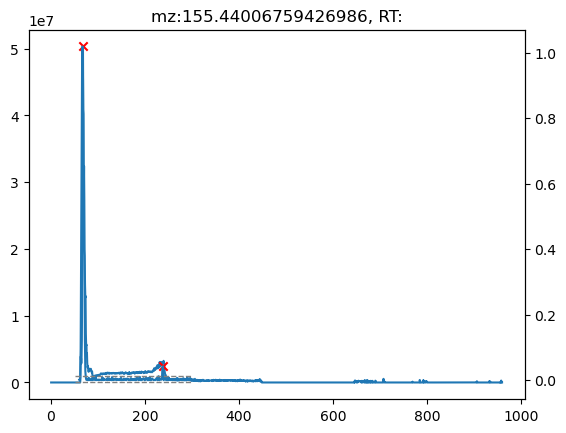

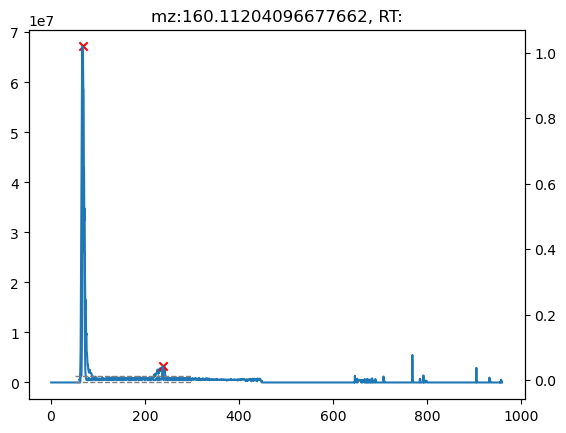

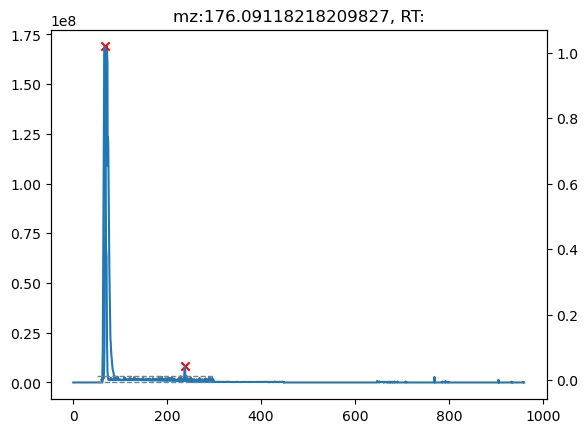

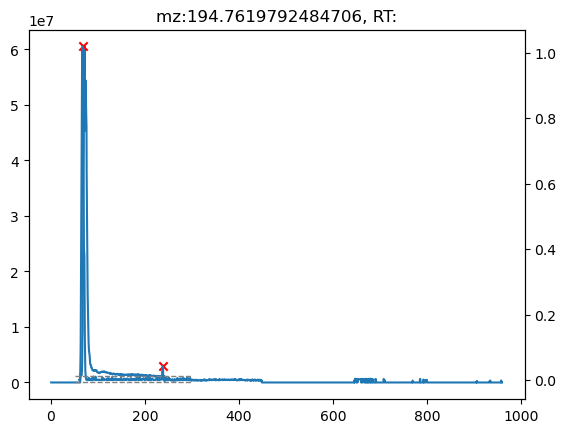

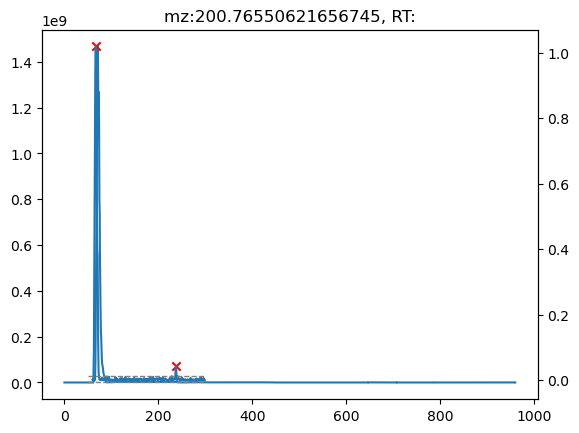

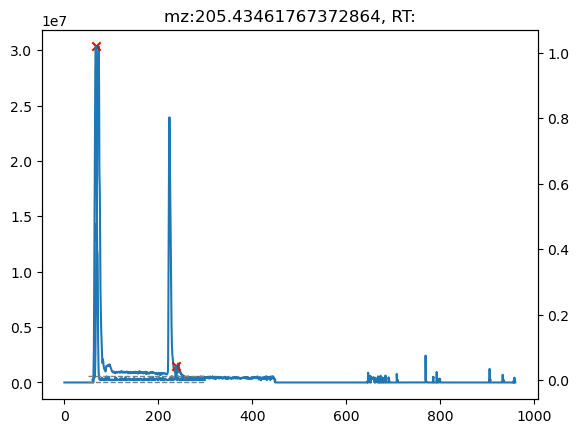

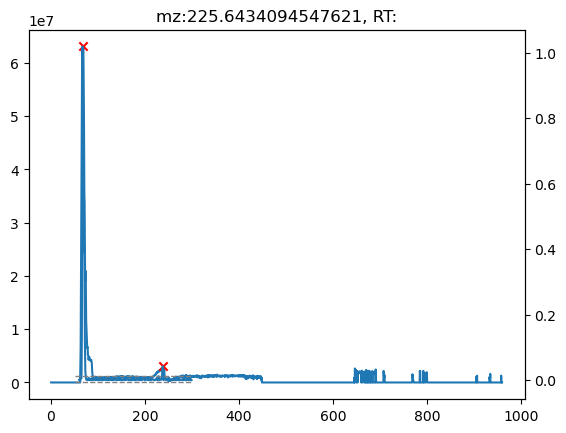

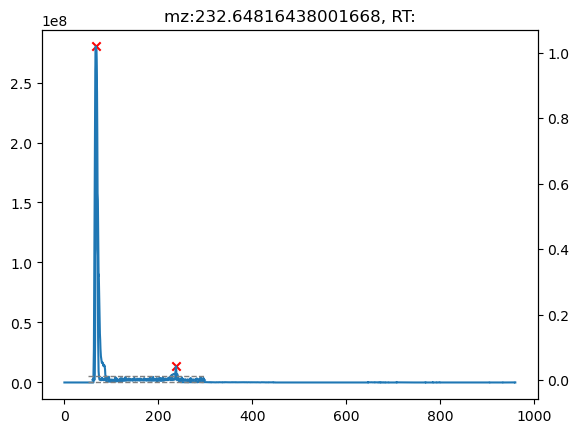

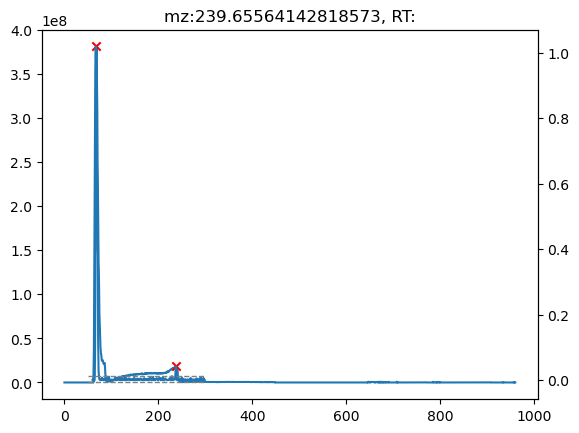

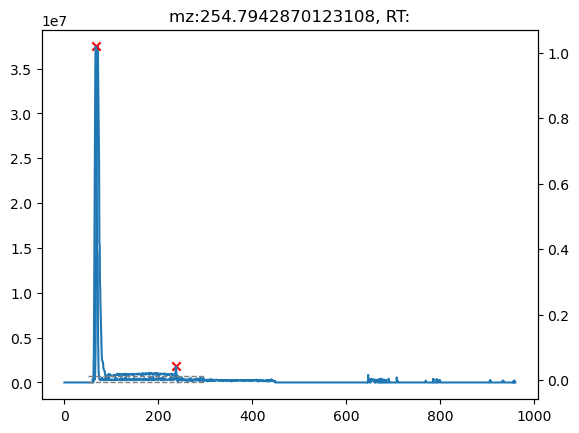

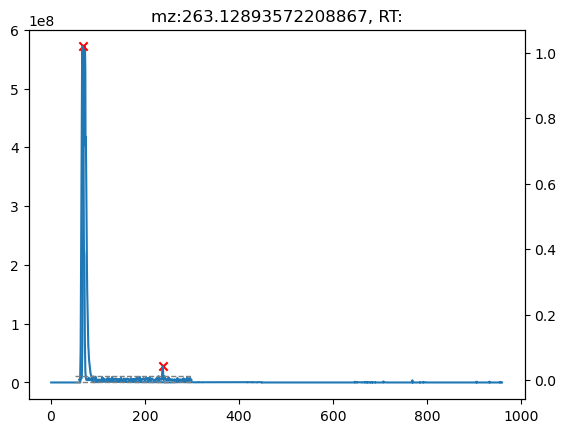

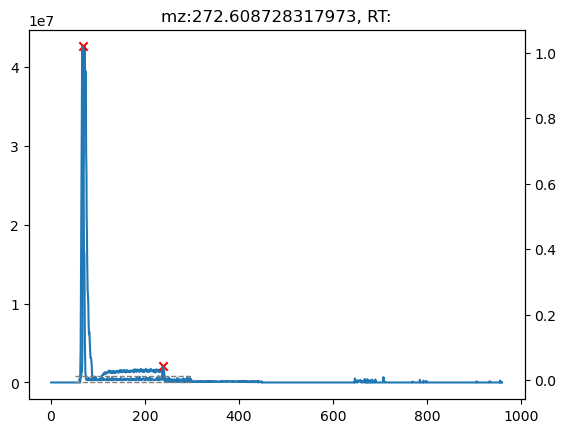

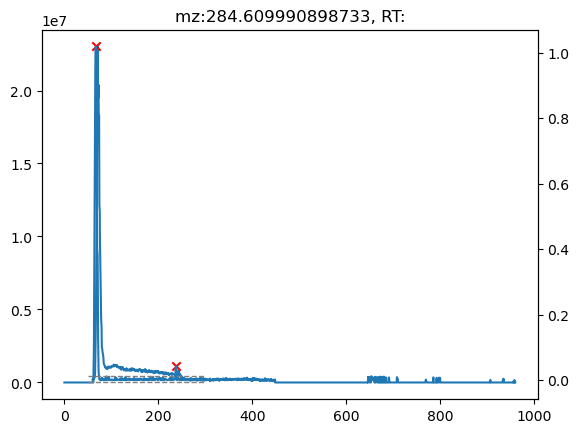

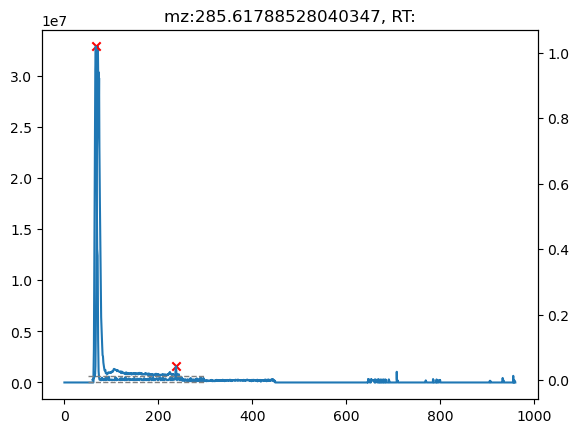

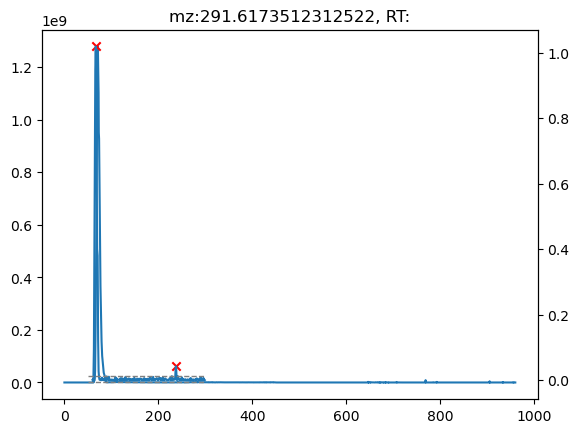

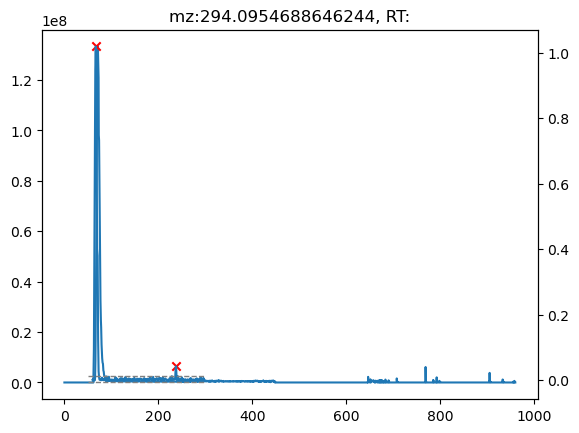

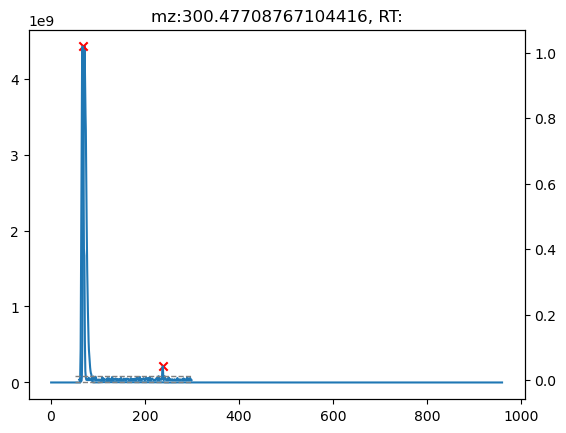

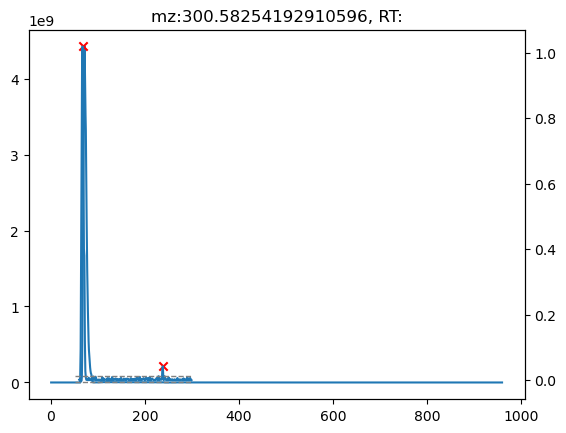

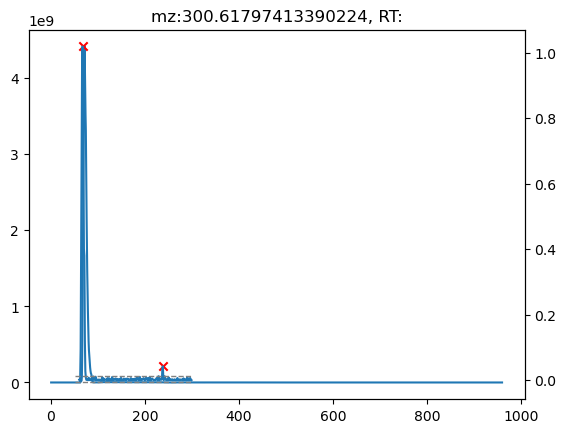

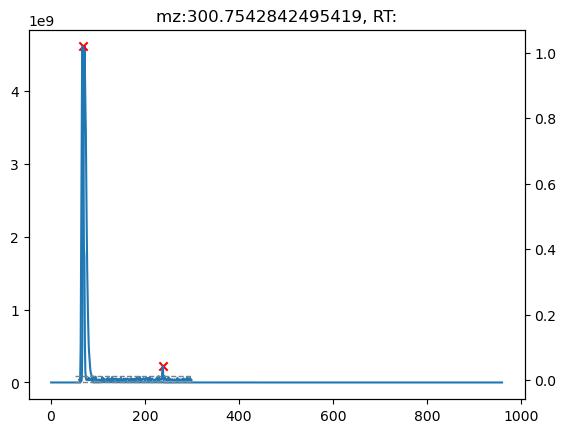

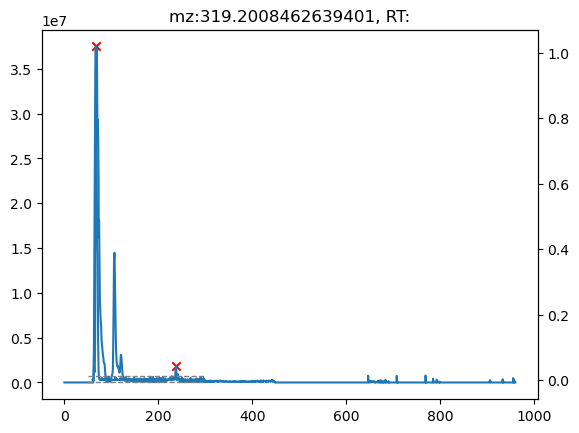

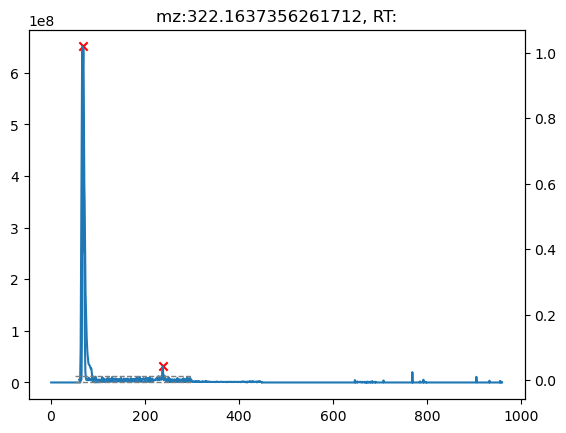

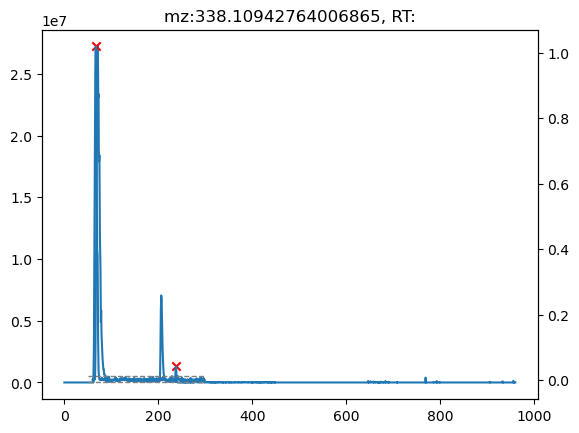

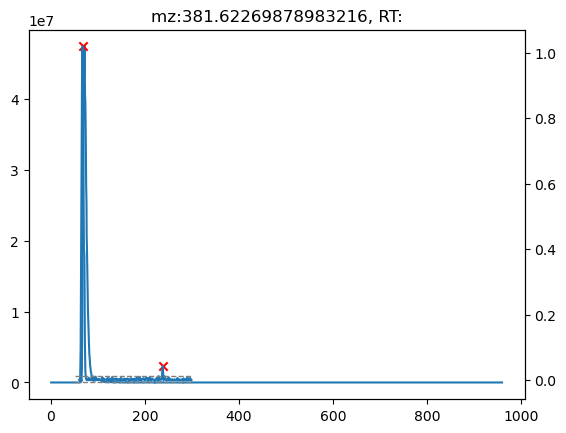

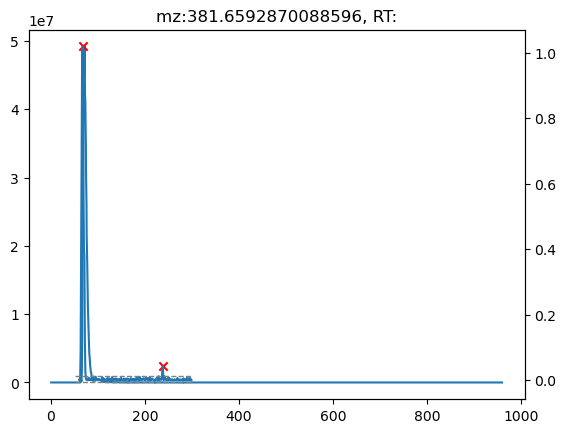

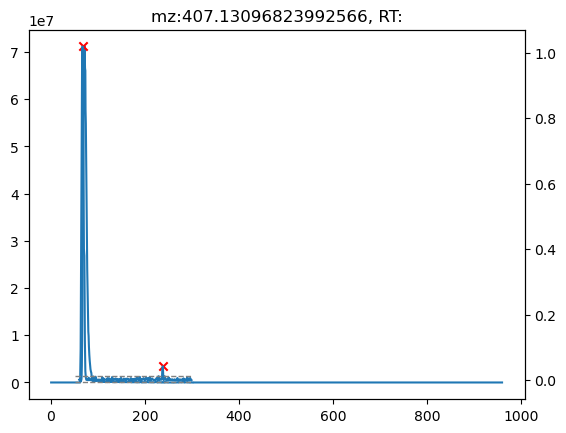

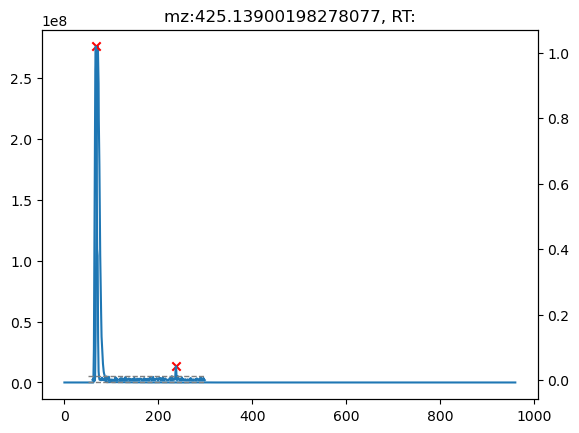

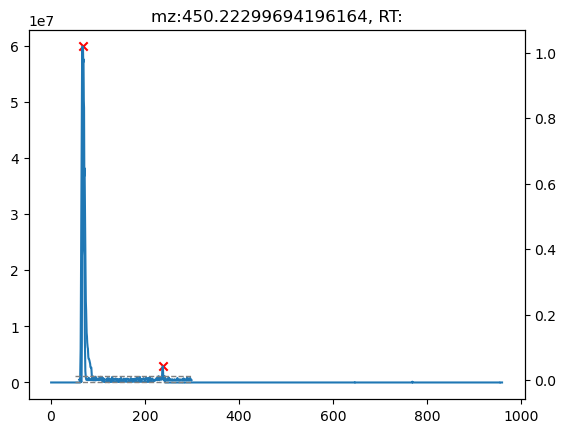

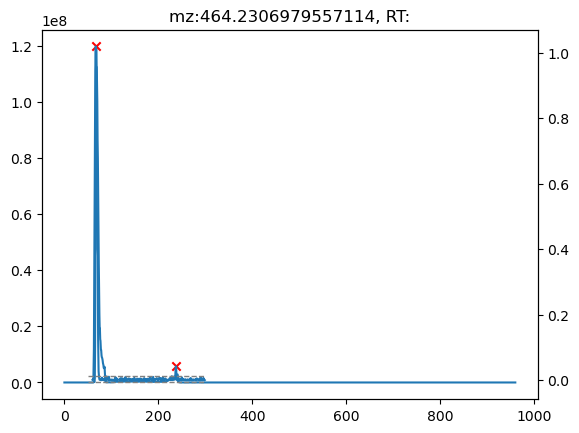

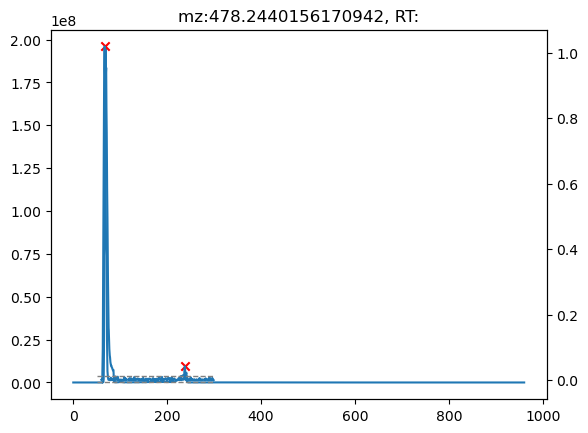

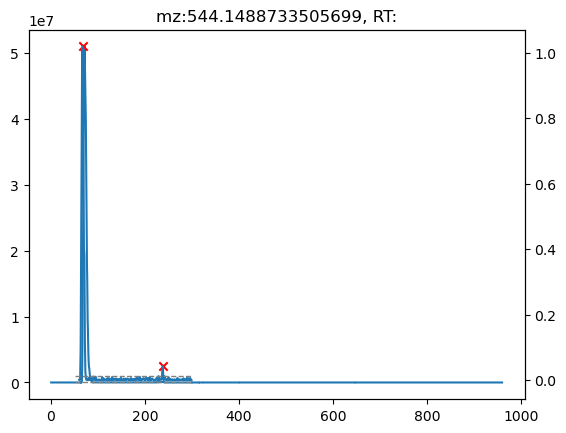

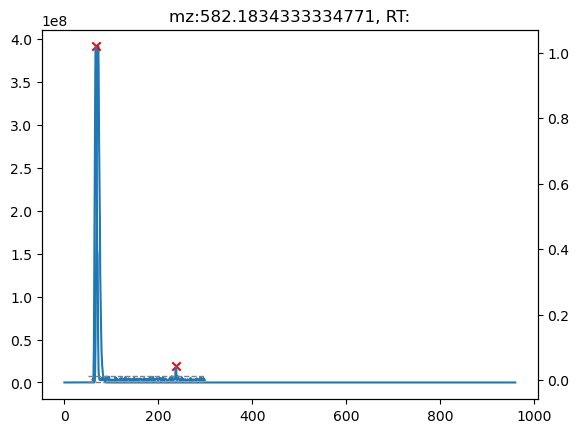

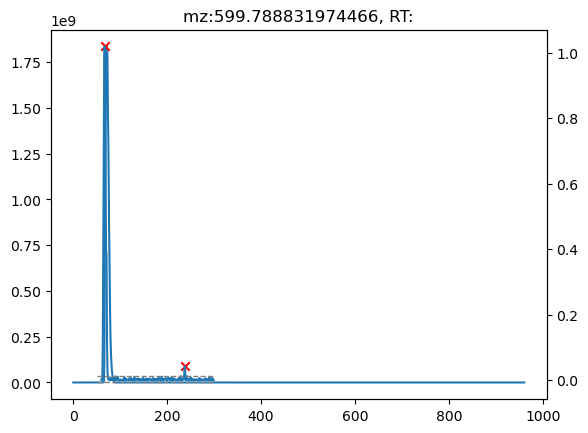

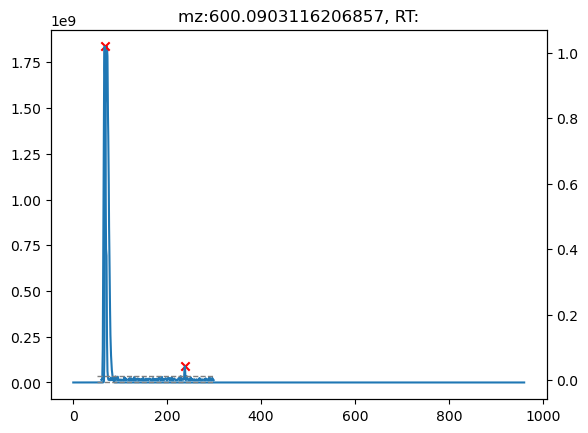

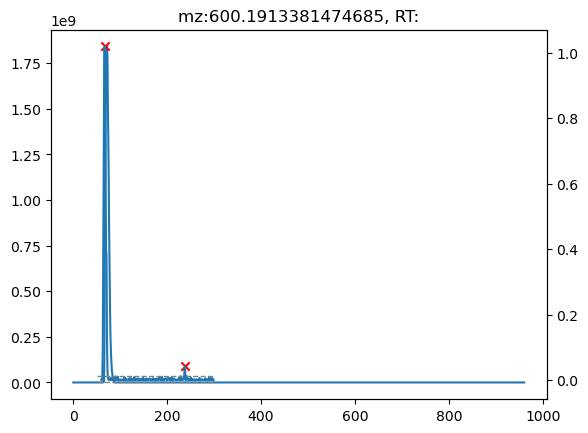

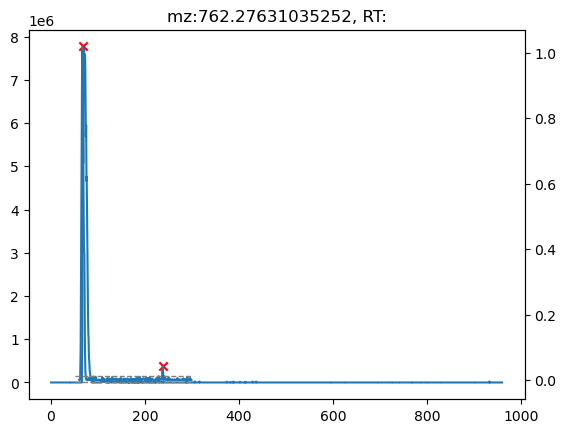

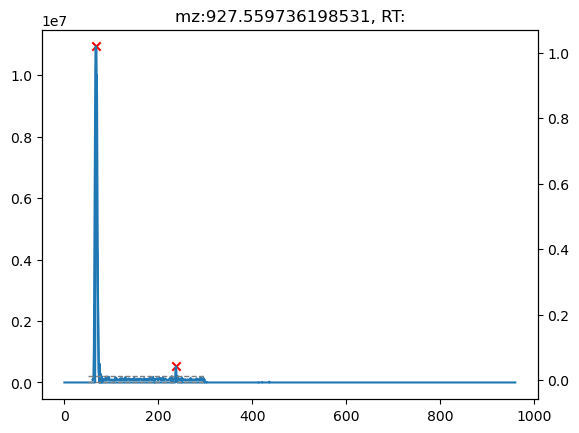

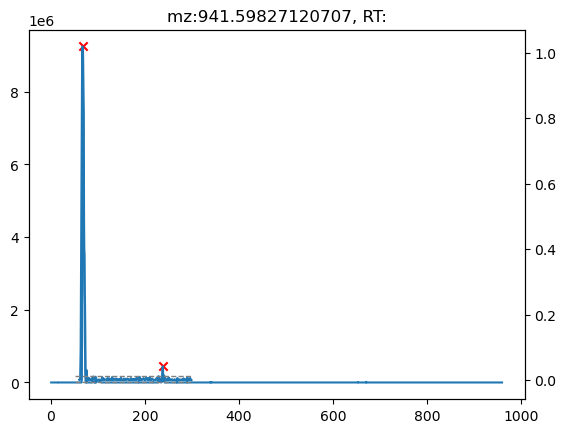

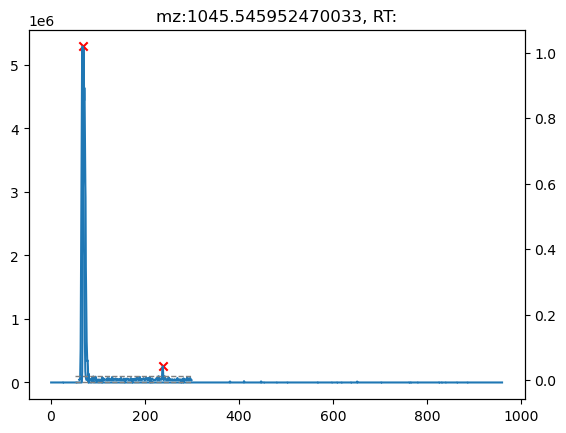

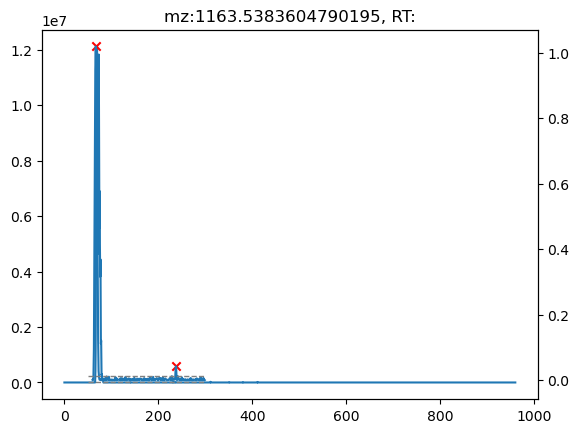

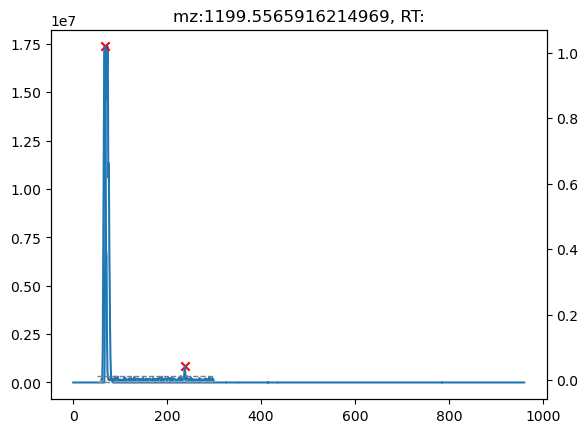

In [5]:
for mz in ft.loc[ft["activity@67.0s"]>0,"mz"]:
    intsum_list=[]
    rtlist=[]
    for spec in exp:
        if spec.getMSLevel()==1:           
            mzval,i=spec.get_peaks()
            intsum=i[(mzval>mz-1) & (mzval<mz+1)].sum()
            rtlist.append(spec.getRT())
            intsum_list.append(intsum)

    fig,ax=plt.subplots()
    ax.plot(rtlist,intsum_list)
    ax.set(title=f"mz:{mz}, RT:")
    
    ax2=ax.twinx()
    ax2.plot(at.RT,at.norm_intensity)
    ax2.scatter(aft.RT,aft.norm_intensity,marker="x",c="red")
    ax2.hlines([mn_old+3*std_old,mn_old-3*std_old],xmin=50,xmax=300,linewidth=1,colors="gray",ls="--")

In [2]:
exp = oms.MSExperiment()
oms.MzMLFile().load("../test_mzml/231004_TestAB_1.mzML", exp)
ft=msu.feature_finding(exp)
ft

Progress of 'mass trace detection':
-- done [took 1.57 s (CPU), 1.67 s (Wall)] -- 
Progress of 'elution peak detection':
-- done [took 1.52 s (CPU), 0.24 s (Wall)] -- 
Progress of 'assembling mass traces to features':
-- done [took 1.48 s (CPU), 0.26 s (Wall)] -- 


,charge,RT,mz,RTstart,RTend,MZstart,MZend,quality,intensity
feature_id,,,,,,,,,
228725091136900609,1,95.152242,150.026161,79.924986,448.631412,150.025726,151.028900,0.000023,2.559386e+06
2767704159861423798,1,242.401938,150.090644,77.889360,341.334360,150.090454,151.096298,0.000101,1.112092e+07
2576680384983257992,3,67.913730,150.768215,63.894474,91.830492,150.768082,151.103149,0.000272,2.657476e+07
14244500815893462567,3,63.178728,150.768746,62.200848,64.139478,150.768356,151.103867,0.000002,2.032671e+05
17581384155642867978,3,68.554974,155.440072,62.446728,141.848514,155.440002,156.110001,0.001316,1.318110e+08
...,...,...,...,...,...,...,...,...,...
2212493265734204825,1,69.675978,1059.556565,66.709224,77.889360,1059.549438,1060.572266,0.000228,2.276587e+07
15003873571039450316,1,68.554974,1063.554474,66.282102,83.933856,1063.551025,1064.561523,0.000232,1.711702e+07
9339549922720715695,1,69.675978,1163.538369,66.282102,82.290612,1163.532959,1165.548340,0.000794,5.305050e+07


,peak_idx,RT,width,left_ips,right_ips,norm_intensity,AUC
252,252,493.0,1.113439,251,252,0.151003,0.147311
257,257,498.0,15.578755,249,264,1.428292,9.750673
270,270,511.0,4.711565,266,270,0.101277,0.229692
279,279,520.0,1.113131,278,279,1.214795,1.100964
283,283,524.0,15.994042,271,287,2.177350,17.175558
290,290,531.0,4.658189,288,292,0.156883,0.404255
308,308,549.0,9.116505,301,310,0.172228,0.600397
312,312,553.0,6.750668,311,317,0.101023,0.308631


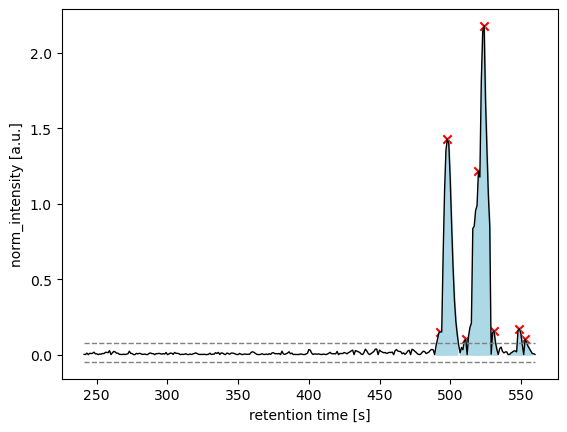

In [7]:
at=pd.read_csv("../output/merged_data.csv",index_col=0)
at.sort_values("RT",inplace=True)
aft=msu.peak_detection(at)

fig,ax=plt.subplots()
plots.plot_activity_chromatogram(fig,ax,at,aft)

aft